In [1]:
### A Pluto.jl notebook ###
# v0.19.41

using Markdown
using InteractiveUtils

In [2]:
using Random, Distributions, StatsBase, Parameters, DataFrames, Plots

# Julian Lethal Mutagenesis Model

## Initialization

In [3]:
Random.seed!(101010)

TaskLocalRNG()

## Conceptual Note
In previous versions of this simulation I had conflated soft selection and carrying capacity.

Soft selection is selection in which reproductive success is a function of relative fitness - something that may arise from competition for limited resources (e.g., hosts assuming their numbers are static/there is no predator-prey feedback). Hard selection implies no adjustment for the fitness of others and we are limited only by instrinsic features of the focal organism (captured in fitness). Now carrying capacity is an abstraction used in the logistic growth model to adjust per capita growth rates as population sizes approach it, but it seems to be tricky to instantiate this in discrete models (esp. with the added complication of semelparity). I've had a go at this but it isn't very realistic.

In simulations in this document with synchronous generations carrying capacity is operative only in so far as individuals are culled at random when the population reaches or exceeds the carrying capacity (making it a concrete limit). This prevents us from having to compute very large population sizes and puts an artificial ceiling on population size (which may be relevant when considering drift). My confusion had arisen because fitness-based culling, or more precisely truncation selection, is a form of extreme soft selection. This is no longer implemented here because it led to double accounting of fitness, stripping it of meaning (see § dead darlings).

I need to read a little bit more into how fitness is calculated in the studies for which the biophysical model provides a good simulacrum, in order to ensure an accurate match, but as written the synchronous simulations (with and without soft selection) show intriguing behaviour.

## Constants
Let's start by defining the constants and parameters in the model:
(Note the `@with_kw` macro is from Parameters.jl)
"""

In [4]:
#@with_kw struct Params
	# physical constants
	kt_boltzmann::Float64 = 0.001987204118 * (273.15+37)
	ΔΔG::Normal{Float64} = Normal(1.0, 1.7)
	
	# fixed parameters
	G::Int = 10 # number_of_genes
	sim_length::Int = 500 # number of generations 500
	F::Float64 = -5.0 # initial_free_energy (of all proteins)
	
	# variable parameters
	U::Poisson{Float64} = Poisson(1.0) # mutation_rate - 4.5
	L::Float64 = 0.1 # lethal_fraction - 0.1
	N::Int = 200 # start_popsize
	K::Int = 200 # carrying_capacity
	R::Int = 4 # fecundity - 4
	#description::String # manual entry
	#replicate::Char # manual entry
#end

4

## Struct and Methods
Next let's specify a Virus struct:

In [5]:
mutable struct Virus
	μ_counts::Vector{Int64}
	ΔG_list::Vector{Float64}
	fitness::Float64
    zombie::Bool
end

And then a function to modify the fitness of a virus:

In [6]:
function update_fitness!(virus::Virus) #, p::Params
	#@unpack kt_boltzmann = p
	# I could check if any ΔG value > 1
    virus.fitness = prod([1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in virus.ΔG_list])
end

update_fitness! (generic function with 1 method)

Note that this is a little approximate:

In [7]:
#begin
    #p = Params(description = "preparatory", replicate = '1')
    start_fitness = prod([1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in fill(F, G)])
#end

0.997007308816621

In [8]:
quentin = Virus(zeros(Int, G), fill(F, G), start_fitness, false)

Virus([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0], 0.997007308816621, false)

In [9]:
update_fitness!(quentin)

0.997007308816621

And now a function to mutate a virus:

In [10]:
quentin.fitness

0.997007308816621

In [11]:
quentin.zombie

false

In [12]:
function mutate!(virus::Virus) #p::Params
	#@unpack G, L, U, ΔΔG = p
	number_of_mutations = only(rand(U, 1))
	ΔΔG_values = rand(ΔΔG, number_of_mutations)
	mutgene_coord = rand((1:G), number_of_mutations)
	for (index, gene_id) in enumerate(mutgene_coord)
		virus.μ_counts[gene_id] += 1
		virus.ΔG_list[gene_id] = virus.ΔG_list[gene_id] + ΔΔG_values[index]
		if only(rand(Float64, 1)) < L
			virus.fitness = 0
		end
	end
	( virus.fitness > 0  ) && ( update_fitness!(virus) )
    if virus.fitness <= 0 # make me efficient!
        virus.zombie = true
    end
    return virus.fitness
end

mutate! (generic function with 1 method)

In [13]:
mutate!(quentin)

0.0

In [14]:
quentin

Virus([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [-5.0, -5.0, -5.0, -4.3726916727471306, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0], 0.0, true)

And now a function to reproduce a virus:

In [15]:
function reproduce(parent::Virus) #, p::Params
    sprog = deepcopy(parent)
    mutate!(sprog)
	return sprog
end

reproduce (generic function with 1 method)

In [16]:
terrence = reproduce(quentin)

Virus([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [-5.0, -5.0, -5.0, -4.3726916727471306, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0], 0.0, true)

## Helper Functions
Now let's develop some helper functions.

Initialize a population:

In [17]:
function initialize_population()
	#@unpack F, G, N = p
	initial_population = [Virus(zeros(Int, G), fill(F, G), start_fitness, false) for _ in 1:N]
    return initial_population
end

initialize_population (generic function with 1 method)

Derive relative fitnesses:

In [18]:
function get_weights(populace)
    weights = [v.fitness for v in populace]
    return Weights(weights/sum(weights))
end

get_weights (generic function with 1 method)

Snap to integer family size probabilistically:

In [19]:
function probabilistic_round(number)
    frac = abs(number - floor(number))
	#frac = number % floor(number)
    if only(rand(Float64, 1)) < frac
        return ceil(Int, number)
	end
    return floor(Int, number)
end

probabilistic_round (generic function with 1 method)

Initialize a report DataFrame with named columns but no data:

In [20]:
function initialize_report()
	report = DataFrame(psiz = Int[], q1fit = Float64[], meanfit = Float64[],
        q2fit = Float64[], maxfit = Float64[], minfree = Float64[], 
		meanfree = Float64[], maxfree = Float64[], minmut = Float64[], 
		meanmut = Float64[], maxmut = Float64[])
	return report
end

initialize_report (generic function with 1 method)

Update report with a row representing data from input population instance (here called populace):

In [21]:
function report_update!(populace, report)
    push!(report, 
		[length(populace), #psiz
		quantile([v.fitness for v in populace], 0.25), #q1fit
		mean([v.fitness for v in populace]), #meanfit
	    median([v.fitness for v in populace]), #q2fit
	    maximum([v.fitness for v in populace]), #maxfit
	    mean([minimum(v.ΔG_list) for v in populace]), #minfree
	    mean([mean(v.ΔG_list) for v in populace]), #meanfree
	    mean([maximum(v.ΔG_list) for v in populace]), #maxfree
	    minimum([sum(v.μ_counts) for v in populace]), #minmut
	    mean([sum(v.μ_counts) for v in populace]), #meanmut
	    maximum([sum(v.μ_counts) for v in populace]), #maxmut
		])
end

report_update! (generic function with 1 method)

Plot a simulation based on the report data and description field:

In [22]:
function plot_simulation(report)
	abscissa = range(1, size(report, 1))
	p1 = plot(abscissa, report.psiz, ylims=(0,maximum(report.psiz)),
		label="pop size", linewidth=3,
		title="A")
	p2 = plot(abscissa, [report.q1fit, report.meanfit, report.q2fit, report.maxfit], 
		label=["Q1 fitness" "mean fitness" "median fitness" "max fitness"], linewidth=3, title="B")
	p3 = plot(abscissa, [report.minfree, report.meanfree, report.maxfree], 
		label=["min ΔG" "mean ΔG" "max ΔG"], 
		linewidth=3, title="C")
	p4 = plot(abscissa, [report.minmut, report.meanmut, report.maxmut],
		label=["min # μ count" "mean # μ" "max # μ"], 
		linewidth=3, title="D")
	plot(p1, p2, p3, p4, titleloc = :left, titlefont = font(20), layout=(2,2), size=(1000, 700))
end

plot_simulation (generic function with 1 method)

## Simulation with Synchronized Generations
Let's construct a simulation in which generations are synchronized and fecundity is a function of R (interpreted as baseline fecundity) and fitness of the focal viral parent. Random culling is carried when the population reaches carrying capacity.

In [23]:
function synchronized_generation(populace)
	#@unpack R = p
	next_generation = []
	for parent in populace
		for r in 1:probabilistic_round(R * parent.fitness)
			child = reproduce(parent)
			( child.fitness > 0  ) && ( push!(next_generation, child) ) # could be a zombie test
		end
	end
	return next_generation
end

synchronized_generation (generic function with 1 method)

In [24]:
function synchronized_simulation()
	#m = Params(description = "synchronized", replicate = '1')
	#@unpack K, N, sim_length = m
	population = initialize_population()
	population_size = N
	report = initialize_report()
	SIM_DURATION = sim_length
	while SIM_DURATION > 0
		SIM_DURATION -= 1
		if SIM_DURATION % 5 == 0 # can change reporting frequency here
			println("generation:", sim_length - SIM_DURATION)
		end
		report_update!(population, report)
		population = synchronized_generation(population)
		population_size = length(population)
		
		if population_size > K
	        population = sample(population, K, replace=false)
		    # why calculate when you can set?
	        population_size = K
	
		elseif population_size == 0
	        # they're all dead
	        SIM_DURATION = 0
		end
	end
	return report
end

synchronized_simulation (generic function with 1 method)

generation:5
generation:10
generation:15
generation:20
generation:25
generation:30
generation:35
generation:40
generation:45
generation:50
generation:55
generation:60
generation:65
generation:70
generation:75
generation:80
generation:85
generation:90
generation:95
generation:100
generation:105
generation:110
generation:115
generation:120
generation:125
generation:130
generation:135
generation:140
generation:145
generation:150
generation:155
generation:160
generation:165
generation:170
generation:175
generation:180
generation:185
generation:190
generation:195
generation:200
generation:205
generation:210
generation:215
generation:220
generation:225
generation:230
generation:235
generation:240
generation:245
generation:250
generation:255
generation:260
generation:265
generation:270
generation:275
generation:280
generation:285
generation:290
generation:295
generation:300
generation:305
generation:310
generation:315
generation:320
generation:325
generation:330
generation:335
generation:340


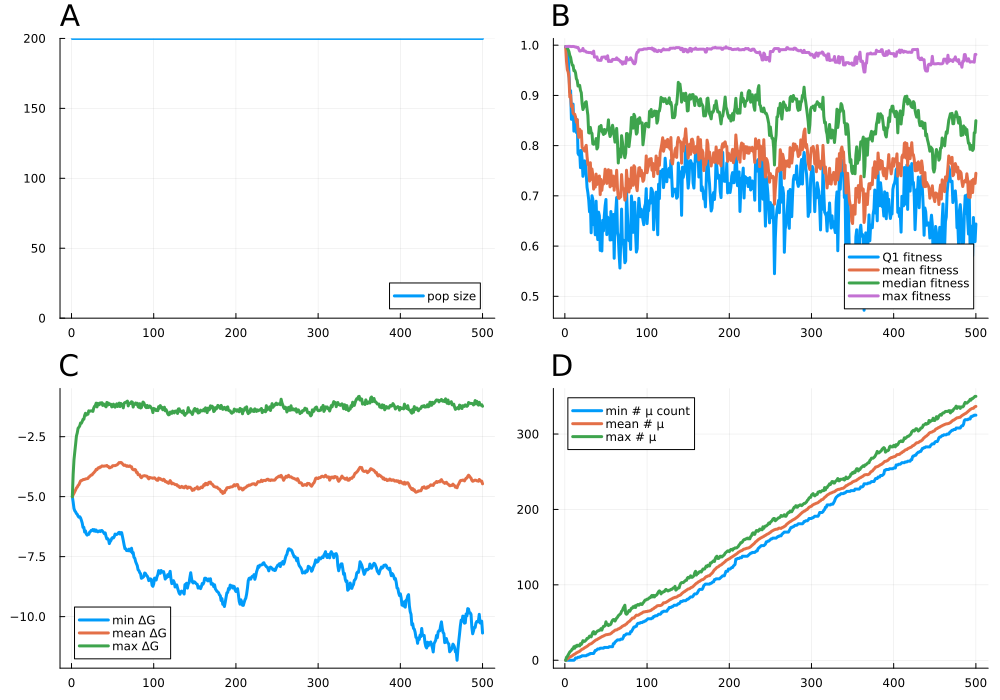

In [25]:
#begin
	synchronized_report = synchronized_simulation()
	plot_simulation(synchronized_report)
	## CSV.write("$(variable_name)", "$(variable_value).csv")
	
	##= using Pkg
	## function save_figure(fig, name_of_variable)
		## filename = ("$(variable_name)", "$(variable_value).png")
		## savefig(fig, filename)
	# end 
#end

In [26]:
synchronized_report

Row,psiz,q1fit,meanfit,q2fit,maxfit,minfree,meanfree,maxfree,minmut,meanmut,maxmut
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,200,0.997007,0.997007,0.997007,0.997007,-5.0,-5.0,-5.0,0.0,0.0,0.0
2,200,0.993053,0.967777,0.997007,0.997533,-5.22376,-4.92308,-4.08002,0.0,0.79,4.0
3,200,0.983927,0.951288,0.994208,0.997495,-5.49582,-4.8597,-3.46501,0.0,1.68,5.0
4,200,0.97717,0.9467,0.991097,0.997565,-5.58987,-4.78881,-3.13144,0.0,2.51,7.0
5,200,0.945119,0.935243,0.987063,0.997695,-5.6348,-4.7187,-2.80955,0.0,3.385,9.0
6,200,0.907289,0.896783,0.979577,0.997552,-5.70474,-4.63837,-2.47061,0.0,4.245,11.0
7,200,0.90939,0.900686,0.975729,0.997552,-5.73668,-4.60273,-2.34102,0.0,4.845,12.0
8,200,0.852383,0.877865,0.966576,0.997305,-5.81175,-4.53484,-2.14743,0.0,5.33,13.0
9,200,0.85928,0.881014,0.960212,0.99733,-5.85632,-4.49973,-2.1084,0.0,6.025,15.0


## Asynchronous (Time-based) Simulation
This simulation picks indviduals as parents proportional to their fitness, while fecundity is always = R. When the population exceed carrying capacity (K) only K parents are picked, otherwise the number of parents is equal to the population size at the beginning of each model step/"generation".

In [27]:
function asynchronous_modelstep!(populace)
	@unpack K, R = p
	population_size = length(populace)
	# loop through population based on fitness
	for _ in 1:minimum([population_size, K])
		# choose single parental index
		parent_idx = sample(1:length(populace), get_weights(populace))
		# we have to use length(populace) because populace is mutated
        # popat! removes parent as reproduction is semelparous
        parent = popat!(populace, parent_idx)
        # note this changes length(populace) but not population_size

        for r in range(1, R) # always have fecundity number of children
            child = reproduce(parent, p)
			( child.fitness > 0  ) && ( push!(populace, child) )
		end
	end
end

asynchronous_modelstep! (generic function with 1 method)

In [28]:
function asynchronous_simulation()
	m = Params(description = "time-based", replicate = '1')
	@unpack K, N, sim_length = m
	population = initialize_population()
	population_size = N
	report = initialize_report()
	SIM_DURATION = sim_length
	while SIM_DURATION > 0
		SIM_DURATION -= 1
		if SIM_DURATION % 5 == 0
			println("generation:", sim_length - SIM_DURATION)
		end
		report_update!(population, report)
		asynchronous_modelstep!(population)
		population_size = length(population)
		
		if population_size == 0
	        # they're all dead
	        SIM_DURATION = 0
		end
	end
	return report
end

asynchronous_simulation (generic function with 1 method)

In [29]:
begin
	asynchronous_report = asynchronous_simulation()
	plot_simulation(asynchronous_report)
end

LoadError: UndefVarError: `Params` not defined

This one takes 28s on my M2 Pro, 32Gb RAM system. We have a lot of growth and numbers expand because viruses sit around not being picked as parents and not inactivating either. It is possibly worth adding an inactivation process in order to implement a form of culling. This would constitute quite a natural system since viruses do fail to find hosts. However, this does alter the meaning of fitness at the margin since a virus can always be picked with low probability by the loop in `asynchronous_modelstep!()`, but inactivation will put paid to this.

## Synchronized Simulation with Soft Selection
This simulation is like the synchronized one except that realized per-capita fecundity is the product of baseline fecundity and relative fitness. Random culling is carried when the population reaches carrying capacity.

In [30]:
function soft_synchron_generation(populace)
	@unpack K, R = p
	pop_size = length(populace)
	mean_fitness = mean([v.fitness for v in populace])

	next_generation = []
	for parent in populace
		family_size = R * (parent.fitness/mean_fitness)
		for r in 1:probabilistic_round(family_size)
			child = reproduce(parent, p)
			( child.fitness > 0  ) && ( push!(next_generation, child) )
		end
	end
	return next_generation
end

soft_synchron_generation (generic function with 1 method)

In [31]:
function softselected_simulation()
	m = Params(description = "softsel synchronised", replicate = '1')
	@unpack K, N, sim_length = m
	population = initialize_population()
	population_size = N
	report = initialize_report()
	SIM_DURATION = sim_length
	while SIM_DURATION > 0
		SIM_DURATION -= 1
		if SIM_DURATION % 5 == 0
			println("generation:", sim_length - SIM_DURATION)
		end
		report_update!(population, report)
		population = soft_synchron_generation(population)
		population_size = length(population)
		
		if population_size > K
	        population = sample(population, K, replace=false)
		    # why calculate when you can set?
	        population_size = K
	
		elseif population_size == 0
	        # they're all dead
	        SIM_DURATION = 0
		end
	end
	return report
end

softselected_simulation (generic function with 1 method)

In [32]:
begin
	softselected_report = softselected_simulation()
	plot_simulation(softselected_report)
end

LoadError: UndefVarError: `Params` not defined

## Asynchronous Simulation with Pseudo-Logistic Growth
This simulation is like the asynchronous one except that the baseline fecundity is scaled based on closeness to carrying capacity (as in logistic model but note this is discrete).

In [33]:
function logistic_async_modelstep!(populace)
	@unpack K, R = p
	pop_size = length(populace)
	scaled_fecundity = R * ((K-pop_size)/pop_size)

	# loop through population based on fitness
	for _ in 1:pop_size
		# choose single parental index
		parent_idx = sample(1:length(populace), get_weights(populace))
		# we have to use length(populace) because populace is mutated
        # popat! removes parent as reproduction is semelparous
        parent = popat!(populace, parent_idx)
        # note this changes length(populace) but not population_size

        for r in 1:probabilistic_round(scaled_fecundity)
            child = reproduce(parent, p)
			( child.fitness > 0  ) && ( push!(populace, child) )
		end
	end
end

logistic_async_modelstep! (generic function with 1 method)

In [34]:
function logistic_async_simulation()
	m = Params(description = "pseudo-logistic", replicate = '1')
	@unpack K, N, sim_length = m
	population = initialize_population()
	population_size = N
	report = initialize_report()
	SIM_DURATION = sim_length
	while SIM_DURATION > 0
		SIM_DURATION -= 1
		if SIM_DURATION % 5 == 0
			println("generation:", sim_length - SIM_DURATION)
		end
		report_update!(population, report)
		logistic_async_modelstep!(population)
		population_size = length(population)
		
		if population_size == 0
	        # they're all dead
	        SIM_DURATION = 0
		end
	end
	return report
end

logistic_async_simulation (generic function with 1 method)

In [35]:
begin
	logistic_async_report = logistic_async_simulation()
	plot_simulation(logistic_async_report)
end

LoadError: UndefVarError: `Params` not defined

Since the population can reach/exceed the carrying capacity this leads to near-immediate extinction in this model owing to semalparity.

I think oscillations (when I tried a version of this with synchronous generations) relate the fact that I have used the logistic growth equation to adjust baseline fecundity; this is calculus-based, but this is a discrete model (see the [logistic map](https://en.wikipedia.org/wiki/Logistic_map)).

## Summary
Really the problem is that fitness has components and our model can include generation time (less is fitter) and fecundity (more is fitter), but an implementation with both risks double counting fitness thereby stripping it of meaning. If fitness is interpreted as lineage growth rate, perhaps we could devise such a combined model, but in order to do this we would need to explictly model latent period and burst size in order to account for their natural limits. We would also need to decide whether mutations can be considered to affect each proportionally. This seems quixotic from a protein model, but we might find data that speaks to mutational effects.

Perhaps we can instead see some limits if we implement an asynchronous model with inactivation (although see my note below the first asynchronous model) and contrast this with a synchronous model with a large carrying capacity (so that this isn't too relevant).

Other forms of realism would include predator-prey feedback.

## Dead Darlings
We used to include the idea of trimming with the following code when the N>K: `population = wsample(population, get_weights(population), K, replace=false)` but we now realise that this double counts fitness.